In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
df=pd.read_csv("phase2_df2(5.18)_newplate.csv",low_memory=False)

In [3]:

from sklearn.preprocessing import StandardScaler

# Timepoint column ranges by regime
timepoint_ranges = {
    '20h_ML': list(range(1, 45)),
    '20h_HL': list(range(1, 45)),
    '2h-2h': list(range(1, 49)),
    '10min-10min': list(range(1, 85)),
    '1min-1min': list(range(1, 89)),
    '30s-30s': list(range(1, 89)),
    '1min-5min': list(range(1, 89)),
    '5min-5min': list(range(1, 89)),
}

# New DataFrame to store standardized values
df_scaled = df.copy()

# Dictionary to store scalers for inverse transformation later
scaler_stats = {}

for regime, tp_range in timepoint_ranges.items():
    y2_cols = [f'y2_{i}' for i in tp_range]
    sub_df = df_scaled[df_scaled['light_regime'] == regime]

    if sub_df.empty:
        continue

    # Standardize and store means/stds
    scaler = StandardScaler()
    scaled_vals = scaler.fit_transform(sub_df[y2_cols])
    
    # Update df
    df_scaled.loc[sub_df.index, y2_cols] = scaled_vals

    # Store mean and std for inverse transform later
    scaler_stats[regime] = pd.DataFrame({
        'mean': scaler.mean_,
        'std': scaler.scale_
    }, index=y2_cols)

In [4]:
df_scaled=pd.read_csv('phase2_df2(5.18)_stand_newplate.csv', index=False)

AttributeError: module 'pandas' has no attribute 'read'

In [90]:
# df_ML=pd.read_csv('all_plate_effects_ML5(5.18).csv')
df_ML=pd.read_csv('all_plate_effects_ML6(5.18).csv')
df_HL=pd.read_csv('all_plate_effects_HL6(5.18).csv')
df_2h=pd.read_csv('all_plate_effects_2h_2h6(5.18).csv')
df_10min=pd.read_csv('all_plate_effects_10min_10min6(5.18).csv')
df_5min=pd.read_csv('all_plate_effects_5min_5min6(5.18).csv')
df_1min_5min=pd.read_csv('all_plate_effects_1min_5min6(5.18).csv')
df_1min=pd.read_csv('all_plate_effects_1min_1min6(5.18).csv')
df_30s=pd.read_csv('all_plate_effects_30s_30s6(5.18).csv')


In [91]:
df_scaled1 = df_scaled.copy()

regime_timepoints = {
    '20h_ML': [f'y2_{i}' for i in range(1, 45)],
    '20h_HL': [f'y2_{i}' for i in range(1, 45)],
    '2h-2h': [f'y2_{i}' for i in range(1, 49)],
    '10min-10min': [f'y2_{i}' for i in range(1, 85)],
    '1min-5min': [f'y2_{i}' for i in range(1, 89)],
    '1min-1min': [f'y2_{i}' for i in range(1, 89)],
    '5min-5min': [f'y2_{i}' for i in range(1, 89)],
    '30s-30s': [f'y2_{i}' for i in range(1, 89)]

}
regime_df_map = {
    '20h_ML': df_ML,
    '20h_HL': df_HL,
    '2h-2h': df_2h,
    '10min-10min': df_10min,
    '5min-5min': df_5min,
    '1min-5min': df_1min_5min,
    '1min-1min': df_1min,
    '30s-30s':df_30s
}


for regime, timepoints in regime_timepoints.items():
    effect_df = regime_df_map[regime]
    effect_sub = effect_df[effect_df['light_regime'] == regime]
    plate_effect_dict = effect_sub.set_index(['plate', 'y2_timepoint'])['plate_effect'].to_dict()

    for tp in timepoints:
        df_scaled1.loc[df_scaled1['light_regime'] == regime, tp] = df_scaled1.loc[
            df_scaled1['light_regime'] == regime
        ].apply(
            lambda row: row[tp] - plate_effect_dict.get((row['plate'], tp), 0),
            axis=1
        )

In [92]:
# tansform back
df_unscaled1 = df_scaled1.copy()

for regime, stats_df in scaler_stats.items():
    # Get timepoint column names
    y2_cols = stats_df.index.tolist()

    # Filter rows for this regime
    idx = df_scaled1['light_regime'] == regime

    # Get means and stds as arrays
    means = stats_df['mean'].values
    stds = stats_df['std'].values

    # Reverse standardization: original = scaled * std + mean
    df_unscaled1.loc[idx, y2_cols] = (
        df_scaled1.loc[idx, y2_cols].values * stds + means
    )

In [93]:
light=['20h_ML','20h_HL','2h-2h','10min-10min','5min-5min','1min-5min','1min-1min','30s-30s']
corrected_df1=df_unscaled1[df_unscaled1['light_regime'].isin(light)]

In [94]:
corrected_df1=corrected_df1.copy()
measurement_cols = [f'measurement_time_{i}' for i in range(91)]  
parsed_times = corrected_df1[measurement_cols].apply(
    pd.to_datetime,
    errors='coerce'  
)

for i, col in enumerate(measurement_cols):
    corrected_df1[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600

## compute slope

In [31]:
def add_y2_slope_and_intercept(hdata):
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(0, 88)]
    response_columns = [f'y2_{i}' for i in range(1, 89)]

    def compute_regression(row):
        time_values = row[time_columns].values.astype(float)
        y_values = row[response_columns].values.astype(float)
        # mask = ~np.isnan(y_values)
        mask = ~np.isnan(y_values) & ~np.isnan(time_values)


        if mask.sum() >= 2:
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])

            return pd.Series({
                'y2_slope': model.coef_[0],
                'y2_intercept': model.intercept_
            })
        return pd.Series({'y2_slope': np.nan, 'y2_intercept': np.nan})

    # Apply regression row-wise
    hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
    
    return hdata

In [95]:
phase2_bay_df=add_y2_slope_and_intercept(corrected_df1)

In [96]:
# Separate WT and mutants
wt_df = phase2_bay_df[phase2_bay_df['mutant_ID'] == 'WT']
mutant_df = phase2_bay_df[phase2_bay_df['mutant_ID'] != 'WT']

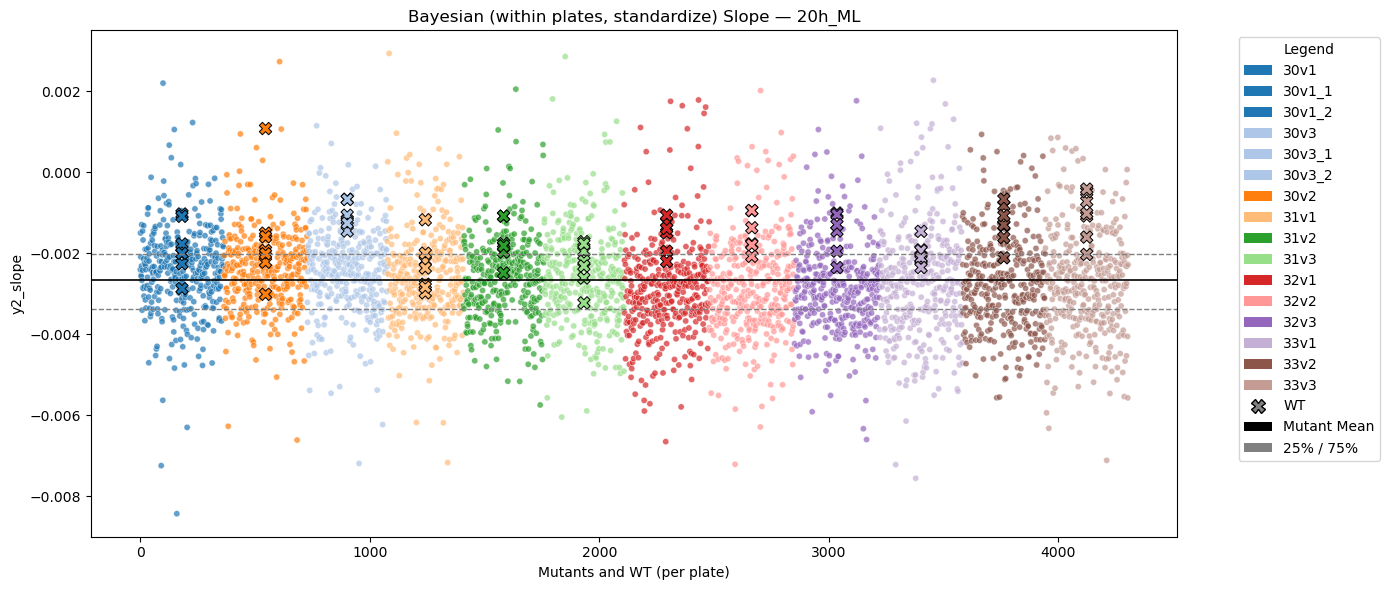

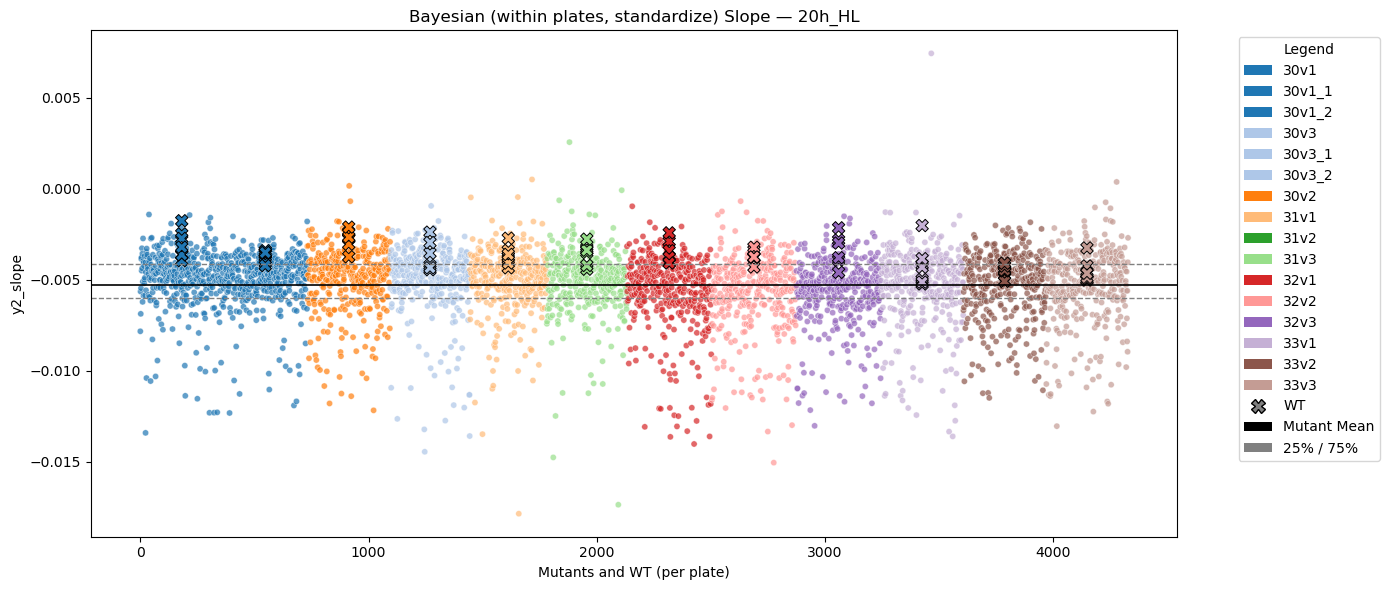

In [97]:
## within plates
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
}

# Define remaining individual plates
individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '33v1', '33v2', '33v3'
]

# Flatten all plates
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate colors
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]


light_regimes = ['20h_ML','20h_HL']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))


    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )

    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Bayesian (within plates, standardize) Slope — {regime}")
    plt.tight_layout()
    plt.show()

## compute 2 slopes

In [98]:
df_alter = phase2_bay_df[phase2_bay_df['light_regime'].isin(['2h-2h','10min-10min', '1min-1min', '30s-30s','5min-5min','1min-5min'])]
df_alter

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_83,elapsed_time_84,elapsed_time_85,elapsed_time_86,elapsed_time_87,elapsed_time_88,elapsed_time_89,elapsed_time_90,y2_slope,y2_intercept
0,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,1,0.628277,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,0.000664,0.329677
1,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,3,0.555580,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,0.000639,0.286291
2,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,4,0.707976,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.000821,0.435237
3,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,5,0.704442,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.001764,0.411676
4,30v1_1,M3,2024-06-10,1min-1min,15.956943,22.289219,180,0,6,0.674942,...,19.073056,19.090000,19.578611,19.595556,20.079722,20.096667,20.352500,NaN,-0.001724,0.388255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34467,31v1,M8,2024-08-03,1min-5min,16.822050,23.617573,180,15,5,0.633003,...,18.953333,19.036944,19.453889,19.537500,19.954444,20.038056,20.293889,NaN,0.000080,0.351690
34468,31v1,M8,2024-08-03,1min-5min,16.822050,23.617573,180,15,6,0.587731,...,18.953333,19.036944,19.453889,19.537500,19.954444,20.038056,20.293889,NaN,0.001301,0.307772
34469,31v1,M8,2024-08-03,1min-5min,16.822050,23.617573,180,15,7,0.664516,...,18.953333,19.036944,19.453889,19.537500,19.954444,20.038056,20.293889,NaN,-0.001676,0.425536
34470,31v1,M8,2024-08-03,1min-5min,16.822050,23.617573,180,15,8,0.610955,...,18.953333,19.036944,19.453889,19.537500,19.954444,20.038056,20.293889,NaN,0.000308,0.315624


In [36]:
light_2h = pd.read_csv('Data light on off/20240917_99v1-M5_2h-2h.csv', sep=';')
light_2h = light_2h.loc[:, ~light_2h.columns.str.contains('^Unnamed')]
light_2h = light_2h.iloc[1:-1].reset_index(drop=True)

light_1min = pd.read_csv('Data light on off/20240913_99v1-M1_1min-1min.csv', sep=';')
light_1min = light_1min.loc[:, ~light_1min.columns.str.contains('^Unnamed')]
light_1min = light_1min.iloc[1:-1].reset_index(drop=True)

light_10min = pd.read_csv('Data light on off/20240919_99v1-M7_10min-10min.csv', sep=';')
light_10min = light_10min.loc[:, ~light_10min.columns.str.contains('^Unnamed')]
light_10min = light_10min.iloc[1:-1].reset_index(drop=True)

light_30s=pd.read_csv('Data light on off/20240918_99v1-M6_30s-30s.csv', sep=';')
light_30s = light_30s.loc[:, ~light_30s.columns.str.contains('^Unnamed')]
light_30s = light_30s.iloc[1:-1].reset_index(drop=True)

light_1min_5min = pd.read_csv('Data light on off/20240920_99v1-M8_1min-5min.csv', sep=';')
light_1min_5min = light_1min_5min.loc[:, ~light_1min_5min.columns.str.contains('^Unnamed')]
light_1min_5min = light_1min_5min.iloc[1:-1].reset_index(drop=True)

light_5min_5min = pd.read_csv('Data light on off/20241123_99v1-M8_5min-5min.csv', sep=';')
light_5min_5min = light_5min_5min.loc[:, ~light_5min_5min.columns.str.contains('^Unnamed')]
light_5min_5min = light_5min_5min.iloc[1:-1].reset_index(drop=True)

In [16]:
def feature_with_light_split(df, light_dict, n_timepoints_dict):
    """
    df: DataFrame in wide format (each row = one mutant)
    light_dict: dict mapping light_regime to corresponding light_XX DataFrame
    n_timepoints_dict: dict mapping light_regime to number of timepoints (40 or 80)
    """

    all_results = []

    for regime, group_df in df.groupby('light_regime'):
        
        if regime not in light_dict:
            continue  # skip if no light info provided for this regime

        light = light_dict[regime]
        n_timepoints = n_timepoints_dict[regime]

        # Extract ON/OFF mask
        par_values = light['PAR'].values[:n_timepoints]
        mask_on = par_values > 0
        mask_off = par_values == 0

        time_cols = [f'elapsed_time_{i}' for i in range(2, n_timepoints + 2)]
        y_cols = [f'y2_{i}' for i in range(1, n_timepoints + 1)]

        def compute_slopes(row):
            
            time_vals = row[time_cols].values.astype(float)
            y_vals = row[y_cols].values.astype(float)
        
            result = {
                'y2_slope_on': np.nan,
                'y2_intercept_on': np.nan,
                'y2_slope_off': np.nan,
                'y2_intercept_off': np.nan,
            }

            # ON
            # valid_on = mask_on & ~np.isnan(y_vals)
            valid_on = mask_on & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_on.sum() >= 2:
                model_on = LinearRegression()
                model_on.fit(time_vals[valid_on].reshape(-1, 1), y_vals[valid_on])
                result['y2_slope_on'] = model_on.coef_[0]
                result['y2_intercept_on'] = model_on.intercept_
        
            # OFF

            # valid_off = mask_off & ~np.isnan(y_vals)
            valid_off = mask_off & ~np.isnan(y_vals) & ~np.isnan(time_vals)

            if valid_off.sum() >= 2:
                model_off = LinearRegression()
                model_off.fit(time_vals[valid_off].reshape(-1, 1), y_vals[valid_off])
                result['y2_slope_off'] = model_off.coef_[0]
                result['y2_intercept_off'] = model_off.intercept_
        
            return pd.Series(result)
        print(regime)

        slopes = group_df.apply(compute_slopes, axis=1)
        result = pd.concat([group_df, slopes], axis=1)
        #.reset_index(drop=True)
        all_results.append(result)

    # Combine results from all regimes
    return pd.concat(all_results, ignore_index=True)

In [99]:
light_dict = {
    '2h-2h': light_2h,
    '10min-10min': light_10min,
    '1min-1min': light_1min,
    '30s-30s': light_30s,
    '5min-5min':light_5min_5min,
    '1min-5min':light_1min_5min
}

n_timepoints_dict = {
    '2h-2h': 48,
    '10min-10min': 84,
    '1min-1min': 88,
    '30s-30s': 88,
    '5min-5min':88,
    '1min-5min':88
}

df1 = feature_with_light_split(df_alter, light_dict, n_timepoints_dict)

10min-10min
1min-1min
1min-5min
2h-2h
30s-30s
5min-5min


In [101]:
# Separate WT and mutants
wt_df =df1[df1['mutant_ID'] == 'WT']
mutant_df =df1[df1['mutant_ID'] != 'WT']

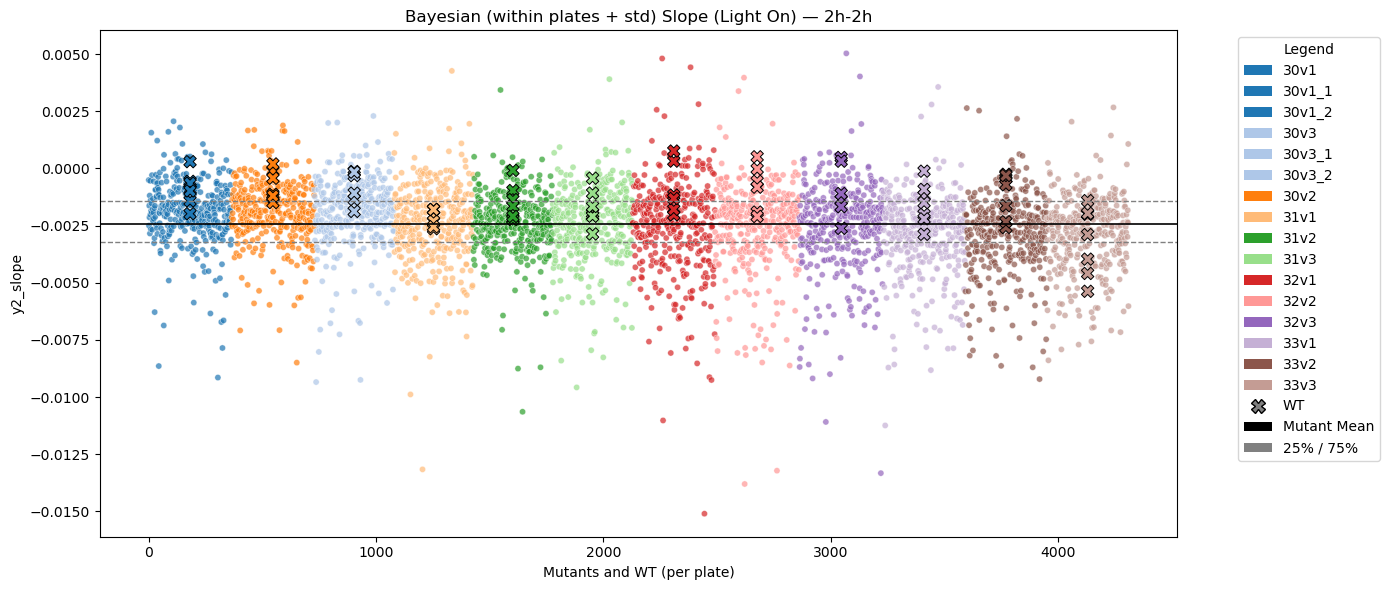

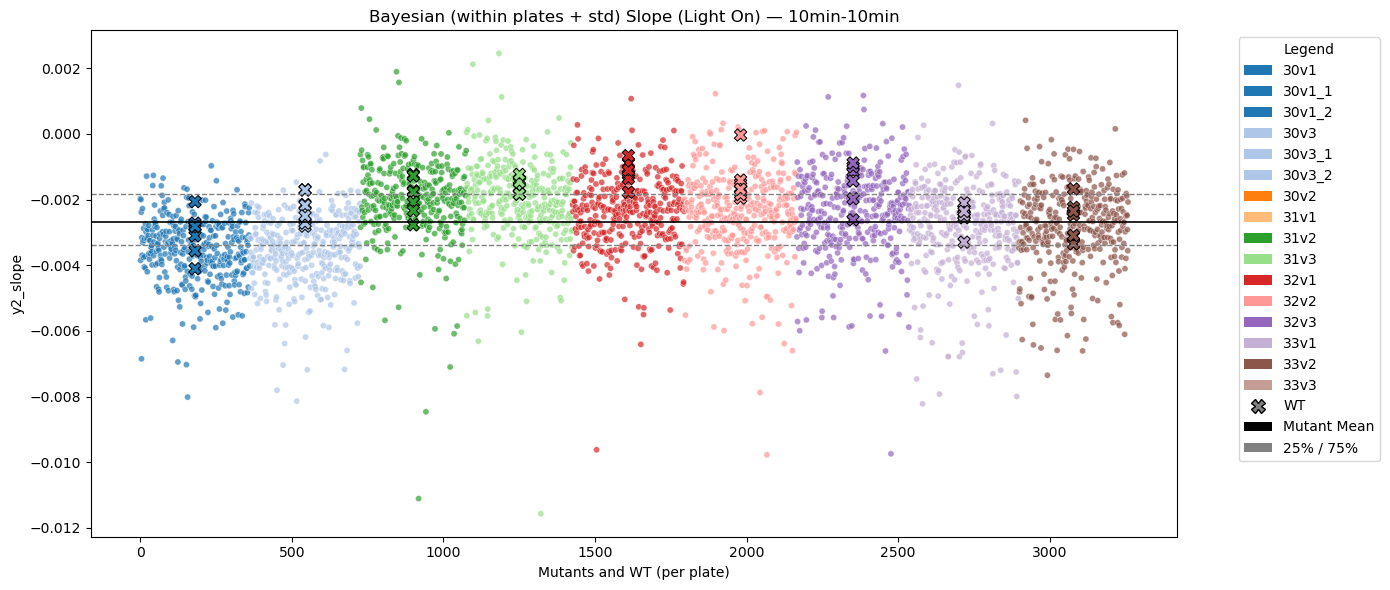

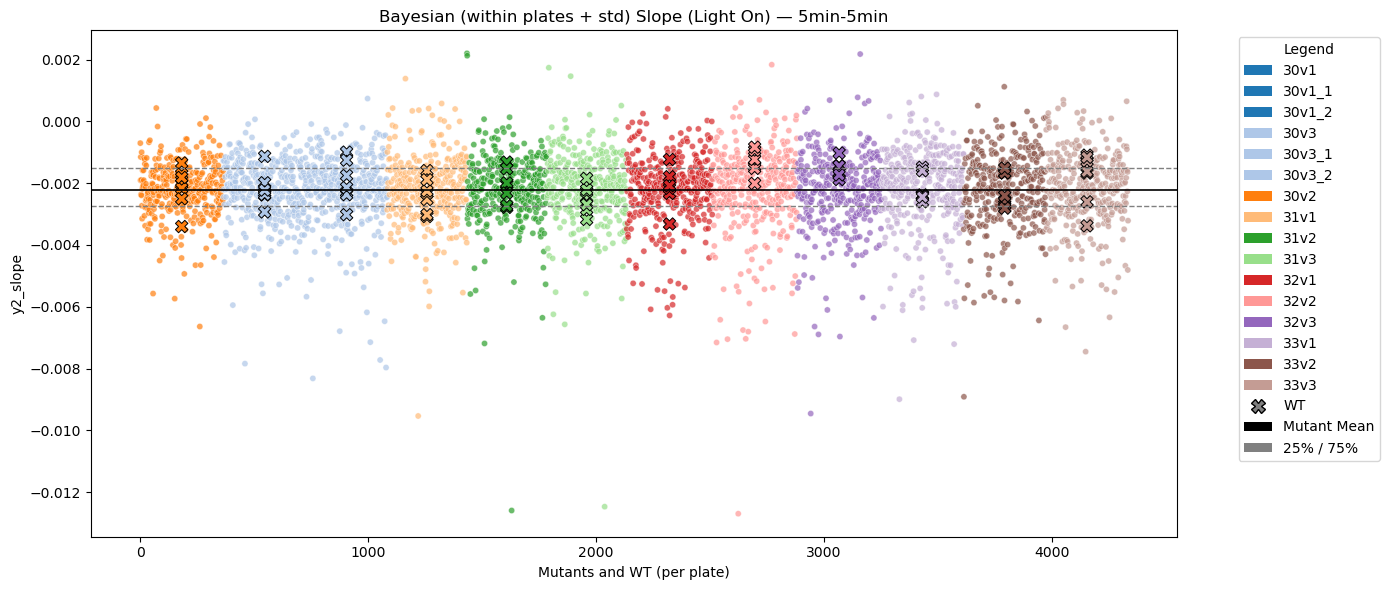

In [102]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
}

individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '33v1', '33v2', '33v3'
]

# Flatten all plates
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate colors
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]


light_regimes = ['2h-2h','10min-10min','5min-5min']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )
    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )
    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Bayesian (within plates + std) Slope (Light On) — {regime}")
    plt.tight_layout()
    plt.show()

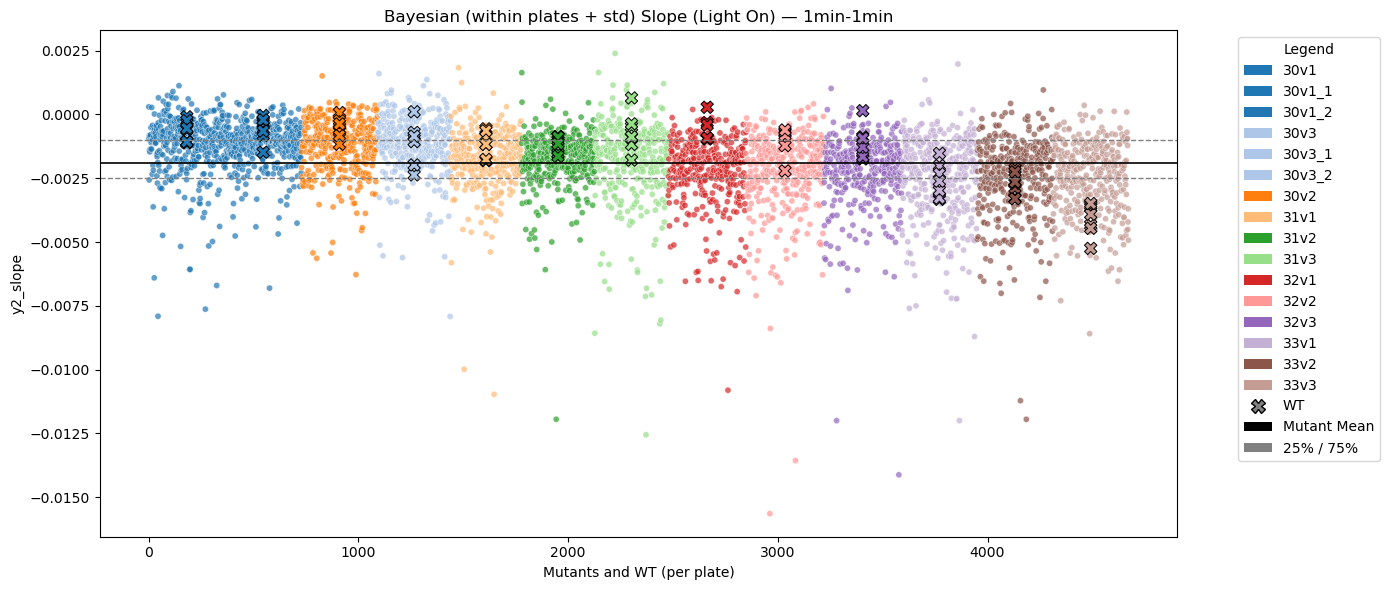

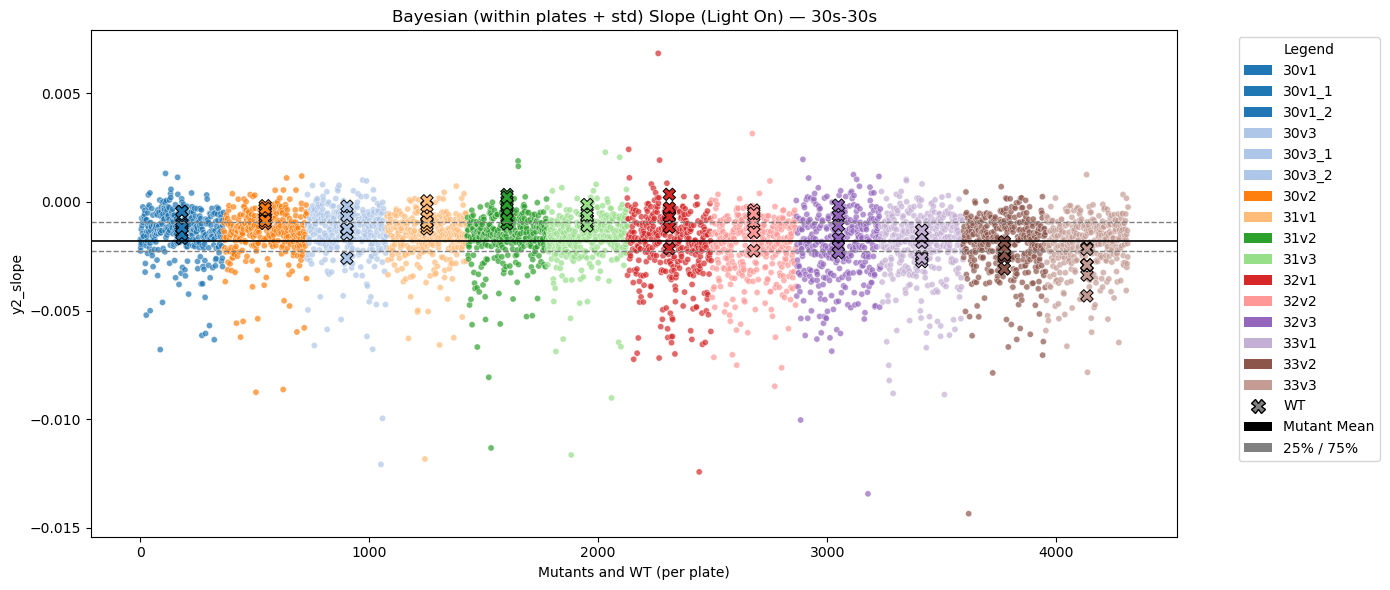

In [87]:
plate_groups = {
    '30v1_group': ['30v1', '30v1_1', '30v1_2'],
    '30v3_group': ['30v3', '30v3_1', '30v3_2'],
}

individual_plates = [
    '30v2',
    '31v1', '31v2', '31v3',
    '32v1', '32v2', '32v3',
    '33v1', '33v2', '33v3'
]

# Flatten all plates
all_plates = sum(plate_groups.values(), []) + individual_plates

# Generate colors
total_needed_colors = len(plate_groups) + len(individual_plates)
base_palette = sns.color_palette('tab20', total_needed_colors)

# Assign colors
plate_to_color = {}

# First assign group colors
for i, (group_name, plates) in enumerate(plate_groups.items()):
    for plate in plates:
        plate_to_color[plate] = base_palette[i]

# Then assign remaining individual plates
for j, plate in enumerate(individual_plates):
    plate_to_color[plate] = base_palette[len(plate_groups) + j]


light_regimes = ['1min-5min','1min-1min','30s-30s']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )
    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )
    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Bayesian (within plates + std) Slope (Light On) — {regime}")
    plt.tight_layout()
    plt.show()

In [103]:
alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s', '5min-5min', '1min-5min']

# 2. Separate out the two subsets
df_alt= df1.copy()  # includes extra columns
df_non_alt = phase2_bay_df[~phase2_bay_df['light_regime'].isin(alt_light_regimes)].copy()

# 3. Make sure df_non_alt has the same columns (add missing columns as NaN)
for col in df_alt.columns:
    if col not in df_non_alt.columns:
        df_non_alt[col] = np.nan

# 4. Reorder columns to match df_alt
df_non_alt = df_non_alt[df_alt.columns]

# 5. Concatenate the full DataFrame
combined_df = pd.concat([df_alt, df_non_alt], ignore_index=True)
combined_df.shape

(34472, 824)

In [104]:
combined_df.to_csv('phase2_bay_std_within_slope(5.18).csv',index=False)